In [6]:
import shabanipy.resonators.billys_code.utils.resonator_functions as rf

import numpy as np

from shabanipy.resonators.billys_code.utils.jy_mpl_settings.settings import jy_mpl_rc
from shabanipy.resonators.billys_code.utils.jy_mpl_settings.colors import line_colors

from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.style.use(jy_mpl_rc)

root = '/Users/billystrickland/Documents/code/resonators/data/'

[Q0, Qtls, nc, beta] [1.96e+05 1.18e+03 3.46e+03 5.00e-01]
error [Q0, Qtls, nc, beta] [1.14e+04 3.79e+02 6.54e+03 4.15e-01]
[Q0, Qtls, nc, beta] [2.14e+05 1.33e+03 1.14e+04 4.90e-01]
error [Q0, Qtls, nc, beta] [1.43e+04 2.60e+02 1.10e+04 3.11e-01]
[Q0, Qtls, nc, beta] [6.31e+04 3.24e+02 1.43e-02 4.90e-01]
error [Q0, Qtls, nc, beta] [1.14e+03 1.44e+04 1.38e+00 4.92e-01]


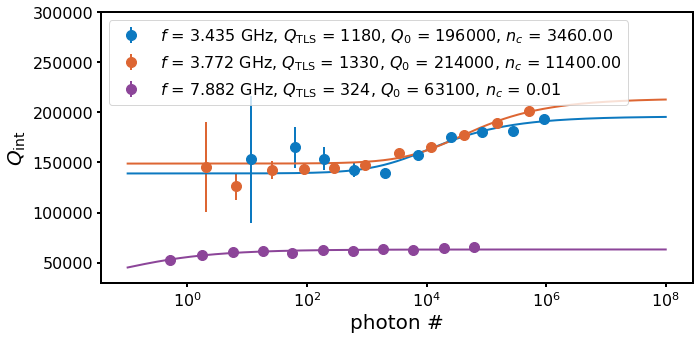

In [7]:
sample = '30SOF7_chipG_MBLJBWMS_CD01'
fig, ax = rf.make_plot_pre('photon #', '$Q_\mathrm{int}$', xscale = 'log', figsize = (10,5))
ax.set_yscale('linear')

markers = ['o', 's', '^', 'D', 'v', 'p', '*', 'H', '3', '2', '1']

def initialize(sample, ID, Q0 =31e3, c = 0, m = 0,Qtls = .85e3, nc = 9e4, label = 'label'):
    file = '/Users/billystrickland/Documents/code/resonators/data/'+sample+'/results/'
    FILES = []
    for i in range(len(ID)):
        FILES.append([file+ID[i]+'.csv'])
    photon_d = np.logspace(-1, 8, 10000)
    photon, qi_diacorr, qi_diacorr_err, freq, freq_err = [],[],[],[],[]
    for i in range(len(FILES)):
        results = rf.proc_csv(FILES[i])            
        photon1, power1, qi_diacorr1, qi_diacorr_err1, qc1, qc_err1, ql1, ql_err1, freq1, freq_err1 = rf.get_results(results, 100000) 
        photon.append(photon1)
        qi_diacorr.append(qi_diacorr1)
        qi_diacorr_err.append(qi_diacorr_err1)

    photon = np.concatenate(photon)
    qi_diacorr = np.concatenate(qi_diacorr)
    qi_diacorr_err = np.concatenate(qi_diacorr_err)
    def func_tls(n, Q0, Qtls, nc, beta):
        kb = 8.617e-5
        h = 4.136e-15
        return 1/((1/Q0)+(1/(Qtls*(1+(n/nc))**beta/np.tanh(h*freq1[0]/kb*(15e-3)))))

    popt, pcov = curve_fit(func_tls, photon, qi_diacorr,sigma = qi_diacorr_err,
                        p0 = [Q0, Qtls, nc, 0.5],
                        bounds=([0, 0,  0, 0.49], [np.inf, np.inf, np.inf, .50001]),
                        maxfev = 1000000000
                       )
    perr = np.sqrt(np.diag(pcov))
    def round_to_n(x, n):
        if x == 0:
            return 0
        else:
            return round(x, -int(np.floor(np.log10(abs(x)))) + (n - 1))

    popt = np.vectorize(lambda x: round_to_n(x, 3))(popt)
    perr = np.vectorize(lambda x: round_to_n(x, 3))(perr)
    print('[Q0, Qtls, nc, beta]', popt)
    print('error [Q0, Qtls, nc, beta]', perr)

    ax.errorbar(np.array(photon),qi_diacorr,yerr=qi_diacorr_err,
                linestyle = 'None',color=line_colors[c], marker = markers[m], 
                label = label+', $Q_\mathrm{TLS}$ = '+str(int(popt[1]))+', $Q_0$ = '+str(int(popt[0]))+f', $n_c$ = {popt[2]:.2f}')
    plt.plot(photon_d, func_tls(photon_d, *popt), 
             color = line_colors[c],)
    plt.ylim(30000, 300000)
#     plt.yscale('log')
    plt.legend()
        
data = [
    {'ID': ['033_0'], 'Q0': 26e3, 'Qtls': 0.6e3, 'c': 0, 'm':0, 'nc': 9e4, 
     'label': '$f$ = 3.435 GHz'},
    {'ID': ['033_1'], 'Q0': 26e3, 'Qtls': 0.6e3, 'c': 1, 'm':0, 'nc': 9e4, 
     'label': '$f$ = 3.772 GHz'},
    {'ID': ['034_0'], 'Q0': 26e3, 'Qtls': 0.6e3, 'c': 2, 'm':0, 'nc': 9e4, 
     'label': '$f$ = 7.882 GHz'},
]

for entry in data:
    initialize(sample, entry['ID'], Q0=entry['Q0'], Qtls=entry['Qtls'], c=entry['c'], m = entry['m'], nc=entry['nc'], label=entry['label'])

fig.tight_layout()
plt.savefig(root+'/'+sample+'/'+'results/power-tls.pdf', format = 'pdf')